In [12]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import random
from collections import Counter
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize

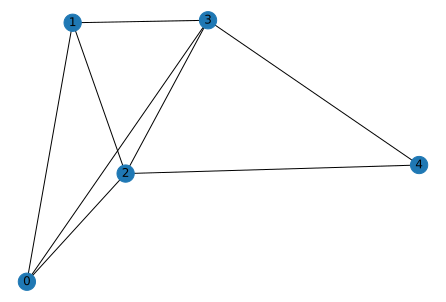

In [13]:
np.random.seed(50)
n_nodes=5
graph = [(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [14]:
def create_params(params):
    alphas = []
    gammas = []
    for i in range(int(len(params)/2)):
        gammas.append(params[2*i])
        alphas.append(params[2*i+1])
    return gammas , alphas



In [15]:
def initialization(circ):
    for i in range(circ.N):
        circ.apply_gate('H',i,gate_round=0)
    return circ

def cost_unitary(circ,gamma,gate_round):
    for edge in graph:
        circ.apply_gate('RZZ', edge[2]*gamma,edge[0], edge[1], gate_round=gate_round)
    return circ

def mixture_unitary(circ,alpha,gate_round):
    for i in range(circ.N):
        circ.apply_gate('RX', alpha, i, gate_round=gate_round)
    return circ

def anasatz(gammas, alphas, n_layers,n_nodes):
    N = n_nodes
    circ = qtn.Circuit(N)
    circ = initialization(circ)
    for i in range(n_layers):
        circ = cost_unitary(circ,gammas[i],gate_round=i)
        circ = mixture_unitary(circ,alphas[i],gate_round=i)
    return circ

def cost_function(params):
    gammas, alphas = create_params(params)
    circ = anasatz(gammas, alphas, p,n)
    cost = 0
    ZZ = qu.pauli('Z') & qu.pauli('Z')
    expns = [circ.local_expectation(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]
    cost = 0.5*(sum(expns).real)
    return cost

In [16]:
def first_guess_linear(p,m1=0.5,m2=0.5):
    theta=np.zeros([2*p])
    for i in range(2*p):
        if i % 2 ==0:
            theta[i]=m1*(i+1)/(2*p)
        else:
            theta[i]=m2*(2*p-i)/(2*p)
    return(theta)
# the index i (i = 0,1,...,p-1) is transformed to a number x_i between 0 and 1 to compare angles for different p
# in the same plot
def x_ungerade(i,p):# for odd angles (gamma's)
    return (i+0.5)/p
    #return (i+0.25)/(p-0.75)   # unclear what is the best choice for x_i
def x_gerade(i,p): # for even angles (beta's)
    return (i+0.5)/p
    #return i/p  # unclear what is the best choice for x_i
def extrapolate(theta):
    p=len(theta)//2+1
    if p<=2: # Extrapolation only makes sense for p>2. Otherwise, take linear guess
        return(first_guess_linear(p))
    else:
        theta2=np.zeros([2*p])
        for i in range(2*p):
            if i % 2 == 0:
                x_func = x_ungerade
                j=0
            else:
                x_func = x_gerade
                j=1
            x=x_func(i//2,p)
            while x_func(j//2 +1,p-1)<x:
                j+=2
            while j//2>p-3:
                j-=2
            x1=x_func(j//2,p-1)
            x2=x_func(j//2+1,p-1)
            y1=theta[j]
            y2=theta[j+2]
            theta2[i]=((y1-y2)*x+x1*y2-y1*x2)/(x1-x2)
            i+=1
    return(theta2)

In [17]:
def plot_histo(data_final, y, optimizer):
    df = pd.DataFrame(np.array(data_final[y].values))
    df.columns = ['a']
    df.index += 1
    df = df.T
    df.columns = ["p_"+str(i) for i in range(1,11)]
    df['optimizer'] = [optimizer]
    print (df)
    solts=  df.melt(id_vars='optimizer').rename(columns=str.title)
    titanic = sns.load_dataset("titanic")
    sns.catplot(x="Optimizer", y="Value",  hue='Variable', kind="bar", data=solts)
    
def plot_line_graph(y):
    #plt.figure(figsize=(10,7))
    x = np.array(range(1,11))
   
    plt.plot(x,y, "-o")
   
    #plt.legend(["COBYLA", "Nelder-Mead", "BFGS"], loc ="lower right")
    plt.xlabel("layers")
    plt.ylabel(y)
    plt.show()

In [18]:
def create_bitstrings(opt_params):
    opt_gammas, opt_alphas = create_params(opt_params)
    opt_circ = anasatz(opt_gammas, opt_alphas, p,n)
    bitstrings = Counter(opt_circ.sample(1000))
    return bitstrings

def get_approximation_ratio(z,b):
    c_z = 0
    c_z_max = 0
    z_a =array_of_key(z)
    for edge in graph:
        c_z = c_z + edge[2]*(1/2)*(1-((1-2*z_a[edge[0]])*(1-2*z_a[edge[1]])))
    for edge in graph:
        c_z_max = c_z_max + edge[2]*(1/2)*(1-((1-2*b[edge[0]])*(1-2*b[edge[1]])))
    app_ratio = c_z / c_z_max
    return app_ratio

def get_maximum_z(counts):
    maximum = 0
    z = ''
    for key in counts.keys():
        if counts[key] > maximum:
            maximum = counts[key]
            z = key 
    return z, maximum

def array_of_key(key):
    hold=[]
    for i in range(0,len(key)):
        hold.append(int(key[i]))
    return hold

In [21]:
ZZ = qu.pauli('Z') & qu.pauli('Z')
n=n_nodes
data_final = pd.DataFrame(columns=[["inital angles" ,  "optimal angles", "opt obj value","p", "optimizer"
                                    ,"ground prob",  "approx ratio"]])
rehss = []
trees = []
flops = []
widths = []
contraction_costs = []
theta = []
for p in range(1,11):
    print('layer :', p)
    
    if len(theta) == 0:
        theta = first_guess_linear(p,m1=0.5,m2=0.5)
        
    init_params = theta
    #print("Initial Guess\n", init_params)
    gammas, alphas = create_params(init_params)
    circ = anasatz(gammas, alphas, p,n)
    local_exp_rehs = [circ.local_expectation_rehearse(edge[2]*ZZ, (edge[0], edge[1]),optimize=opt) for edge in graph]
    edge_wise_rehs = []
    edge_wise_trees = []
    edge_wise_flops = []
    edge_wise_widths = []
    edge_wise_contraction_costs = []
    for rehs in local_exp_rehs:
        edge_wise_rehs.append(rehs)
        edge_wise_widths.append(rehs['W'])
        edge_wise_contraction_costs.append(rehs['C'])
        tree = ctg.ContractionTree.from_info(rehs['info'])
        edge_wise_trees.append(tree)
        edge_wise_flops.append(tree.total_flops())
        
    rehss.append(edge_wise_rehs)
    trees.append(edge_wise_trees)
    flops.append(edge_wise_flops)
    widths.append(edge_wise_widths)
    contraction_costs.append(edge_wise_contraction_costs)
    
    method = "COBYLA"
    print("Initial Guess\n", init_params)
    out = minimize(cost_function, x0=init_params, method=method, options={'maxiter':300})
    print(out)
    bitstrings = create_bitstrings(out.x)
    
    
    z , maxm = get_maximum_z(bitstrings)
    print("z with maximum frequency: "+str(z))
    r = get_approximation_ratio(z,b)
    print("approxiamation ratio: "+str(r))
    gse = out.fun
    print("gse: "+str(gse))
    print("prob of maxm string: "+str(maxm/1000))
    
    
    
    data = pd.DataFrame([ [init_params], [out.x],[gse], [p], ['skopt'],[maxm/1000], [r]]) 
    
    data = data.T
    
    data.columns=[["inital angles" ,  "optimal angles", "opt obj value", "p", "optimizer", "ground prob",  "approx ratio"]]

    data_final = data_final.append(data)
    theta = list(out.x)
    for i in range(2):
        theta.append(0)

layer : 1
Initial Guess
 [0.25 0.25]
     fun: -4.8982556865403355
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 300
  status: 2
 success: False
       x: array([0.21276373, 1.3558904 ])
z with maximum frequency: 11000
approxiamation ratio: 0.9166666666666666
gse: -4.8982556865403355
prob of maxm string: 0.1
layer : 2
Initial Guess
 [0.21276373039336116, 1.355890399958068, 0, 0]
     fun: -4.932520042523712
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 300
  status: 2
 success: False
       x: array([0.21125568, 1.36302117, 0.05267157, 0.03010891])
z with maximum frequency: 11000
approxiamation ratio: 0.9166666666666666
gse: -4.932520042523712
prob of maxm string: 0.113
layer : 3
Initial Guess
 [0.21125568345922605, 1.363021174220492, 0.05267156998462557, 0.03010890649136612, 0, 0]
     fun: -5.07734466085395
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'

In [9]:
import cotengra as ctg


opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
    
)

C:\Users\EXPERT\anaconda3\lib\site-packages\cotengra\hyper.py:20: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [10]:
N = 5
A=np.zeros((int(N),int(N)))
for i in graph:
    A[i[0]][i[1]] = i[2]
    A[i[1]][i[0]] = i[2]
    
best_cost_brute = 0
for b in range(2**N):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(N)))]
    cost = 0
    for i in range(N):
        for j in range(N):
            cost = cost + A[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))
b = xbest_brute


Best solution = [0, 0, 1, 1, 0] cost = 24.0


approx ratio
        p_1       p_2       p_3       p_4       p_5       p_6  p_7  p_8  p_9  \
a  0.916667  0.916667  0.916667  0.916667  0.916667  0.916667  1.0  1.0  1.0   

  p_10 optimizer  
a  1.0     skopt  


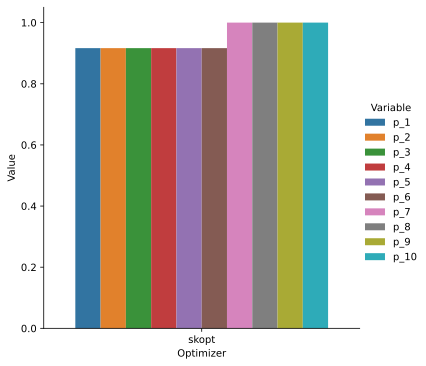

In [22]:
op = "skopt"
y = "approx ratio"
print("approx ratio")
plot_histo(data_final, y, op)

ground state
        p_1      p_2       p_3       p_4       p_5       p_6      p_7  \
a -4.898256 -4.93252 -5.077345 -5.085927 -6.498263 -6.656438 -7.36276   

        p_8      p_9      p_10 optimizer  
a -7.596948 -7.74229 -7.815128     skopt  


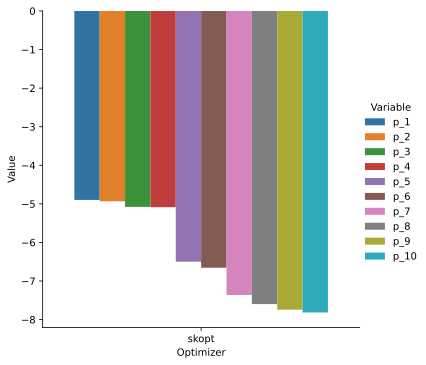

In [23]:
print("ground state")
y = "opt obj value"
plot_histo(data_final, y, op)

Frequency of the optimal bitstring
   p_1    p_2    p_3    p_4    p_5    p_6    p_7    p_8    p_9   p_10  \
a  0.1  0.113  0.128  0.118  0.201  0.168  0.204  0.231  0.251  0.251   

  optimizer  
a     skopt  


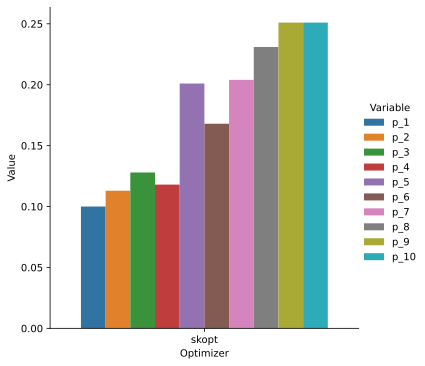

In [24]:
print("Frequency of the optimal bitstring")
y = "ground prob"
plot_histo(data_final, y, op)

In [25]:
data_final

,inital angles,optimal angles,opt obj value,p,optimizer,ground prob,approx ratio
0,"[0.25, 0.25]","[0.21276373039336116, 1.355890399958068]",-4.898256,1,skopt,0.1,0.916667
0,"[0.21276373039336116, 1.355890399958068, 0, 0]","[0.21125568345922605, 1.363021174220492, 0.052...",-4.93252,2,skopt,0.113,0.916667
0,"[0.21125568345922605, 1.363021174220492, 0.052...","[0.20313590148328906, 1.388288712650039, 0.071...",-5.077345,3,skopt,0.128,0.916667
0,"[0.20313590148328906, 1.388288712650039, 0.071...","[0.20133604014707002, 1.3995136569775295, 0.07...",-5.085927,4,skopt,0.118,0.916667
0,"[0.20133604014707002, 1.3995136569775295, 0.07...","[0.2059457899434227, 1.4460438664564712, -0.16...",-6.498263,5,skopt,0.201,0.916667
0,"[0.2059457899434227, 1.4460438664564712, -0.16...","[0.2036204345588716, 1.4471065315648788, -0.17...",-6.656438,6,skopt,0.168,0.916667
0,"[0.2036204345588716, 1.4471065315648788, -0.17...","[0.20456108143562188, 1.4499231084409965, -0.1...",-7.36276,7,skopt,0.204,1.0
0,"[0.20456108143562188, 1.4499231084409965, -0.1...","[0.20500888132559797, 1.4581677649513618, -0.1...",-7.596948,8,skopt,0.231,1.0
0,"[0.20500888132559797, 1.4581677649513618, -0.1...","[0.20603472741226914, 1.47487804036721, -0.178...",-7.74229,9,skopt,0.251,1.0
0,"[0.20603472741226914, 1.47487804036721, -0.178...","[0.20660541725540651, 1.479621296058226, -0.17...",-7.815128,10,skopt,0.251,1.0


In [26]:
A=np.zeros((int(N),int(N)))
for i in graph:
    A[i[0]][i[1]] = i[2]
    A[i[1]][i[0]] = i[2]

In [27]:
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\optimization\__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


In [28]:
qubitOp, offset = max_cut.get_operator(A)

C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\optimization\applications\ising\max_cut.py:54: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  return WeightedPauliOperator(paulis=pauli_list), shift


In [29]:
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, A))

energy: -10.0
max-cut objective: -24.0
solution: [0 0 1 1 0]
solution objective: 24.0


C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\algorithms\minimum_eigen_solvers\minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\algorithms\eigen_solvers\eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',
C:\Users\EXPERT\anaconda3\lib\site-packages\qiskit\aqua\operators\state_fns\vector_state_fn.py:215: DeprecationWarning

        p_1       p_2       p_3       p_4       p_5       p_6       p_7  \
a  0.489826  0.493252  0.507734  0.508593  0.649826  0.665644  0.736276   

        p_8       p_9      p_10 optimizer  
a  0.759695  0.774229  0.781513     skopt  


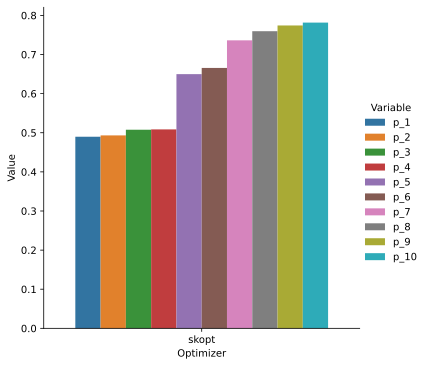

In [30]:
# Approx ratio of ebnergies

y = "opt obj value"
optimizer = "skopt"
df = pd.DataFrame(np.array(data_final[y].values/result.eigenvalue.real))
df.columns = ['a']
df.index += 1
df = df.T
df.columns = ["p_"+str(i) for i in range(1,11)]
df['optimizer'] = [optimizer]
print (df)
solts=  df.melt(id_vars='optimizer').rename(columns=str.title)
titanic = sns.load_dataset("titanic")
sns.catplot(x="Optimizer", y="Value",  hue='Variable', kind="bar", data=solts)